In [77]:
import numpy as np
import matlab.engine
import math
import csv

mle = matlab.engine.start_matlab('-desktop')

In [34]:
STOP_TIME = 45
START_TIME = 5

In [35]:
def getApogee(result_matlab):
    velocity_data = result_matlab['velocity']['Data']
    velocity_time = result_matlab['velocity']['Time']
    height_data = result_matlab['height']['Data']
    height_time = result_matlab['height']['Time']

    #find time when apogee hit
    apogee_index = -1
    for i in range(0,len(velocity_data)):
        if (velocity_data[i][0]<=0 and i>1):
            apogee_index = i
            break

    if (apogee_index != -1):
        #find time when apogee hit
        apogee_time = velocity_time[apogee_index][0]
        return height_data[apogee_index][0]
    else:
        return -1 #INVALID APOGEE
    

In [38]:
def get_extension(curr_vel, curr_alt,target, temperature):
    #find apogee when no extension yet
    params = {
        'current_height': curr_alt,
        'current_vel':curr_vel,
        'current_pitch':0.0,
        'extension_length':0.0,
        'temperature': temperature  # (in K)
    }

    #0% extension
    result = mle.sim_the_model('Stoptime',STOP_TIME,"StartTime", START_TIME,'TunableParameters',params)
    curr_apog = getApogee(result)
    
    #already undershooting
    if curr_apog<target:
        return 0
    else:
        return 100


In [48]:
get_extension(260.0,0.0, 9144.0,293.0)

0

In [54]:
LUT = [[0,0]]*261

In [63]:
STARTING_HEIGHT = 5000.0

def generate_LUT_temp_apog(target_apogee, surface_temp):
    prev_height = STARTING_HEIGHT
    
    for i in range(260, -1, -1):
        height = prev_height
        
        if (height>=target_apogee):
            LUT[i] = [i, target_apogee]
        
        while (height<target_apogee):     
            curr_extension = get_extension(float(i), float(height), target_apogee, surface_temp)

            if (curr_extension==100):
                prev_height = height
                LUT[i] = [i, height]
                break

            height += 10.0 
            
        print("running velocity: " + str(i) + " result height is: "+ str(height))

    for i in range(0,261):
        if (LUT[i][1] == 0 or LUT[i][1]>=target_apogee):
            LUT[i]= [i, target_apogee]
    
    path = "./SAC_LUT/LUT_"+ str(target_apogee)+"_"+str(surface_temp) + ".csv"
    with open(path,"w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(LUT)

In [64]:
generate_LUT_temp_apog(9144.0, 293.0)

running velocity: 260 result height is: 6040.0
running velocity: 259 result height is: 6060.0
running velocity: 258 result height is: 6080.0
running velocity: 257 result height is: 6100.0
running velocity: 256 result height is: 6130.0
running velocity: 255 result height is: 6150.0
running velocity: 254 result height is: 6170.0
running velocity: 253 result height is: 6190.0
running velocity: 252 result height is: 6210.0
running velocity: 251 result height is: 6230.0
running velocity: 250 result height is: 6250.0
running velocity: 249 result height is: 6270.0
running velocity: 248 result height is: 6290.0
running velocity: 247 result height is: 6310.0
running velocity: 246 result height is: 6330.0
running velocity: 245 result height is: 6350.0
running velocity: 244 result height is: 6370.0
running velocity: 243 result height is: 6400.0
running velocity: 242 result height is: 6420.0
running velocity: 241 result height is: 6440.0
running velocity: 240 result height is: 6460.0
running veloc

In [67]:
print(LUT)

[[0, 9144.0], [1, 9144.0], [2, 9144.0], [3, 9144.0], [4, 9144.0], [5, 9144.0], [6, 9144.0], [7, 9144.0], [8, 9144.0], [9, 9140.0], [10, 9140.0], [11, 9140.0], [12, 9140.0], [13, 9140.0], [14, 9140.0], [15, 9140.0], [16, 9140.0], [17, 9130.0], [18, 9130.0], [19, 9130.0], [20, 9130.0], [21, 9130.0], [22, 9120.0], [23, 9120.0], [24, 9120.0], [25, 9120.0], [26, 9110.0], [27, 9110.0], [28, 9110.0], [29, 9110.0], [30, 9100.0], [31, 9100.0], [32, 9100.0], [33, 9090.0], [34, 9090.0], [35, 9090.0], [36, 9080.0], [37, 9080.0], [38, 9080.0], [39, 9070.0], [40, 9070.0], [41, 9060.0], [42, 9060.0], [43, 9060.0], [44, 9050.0], [45, 9050.0], [46, 9040.0], [47, 9040.0], [48, 9030.0], [49, 9030.0], [50, 9020.0], [51, 9020.0], [52, 9010.0], [53, 9010.0], [54, 9000.0], [55, 9000.0], [56, 8990.0], [57, 8980.0], [58, 8980.0], [59, 8970.0], [60, 8970.0], [61, 8960.0], [62, 8950.0], [63, 8950.0], [64, 8940.0], [65, 8940.0], [66, 8930.0], [67, 8920.0], [68, 8910.0], [69, 8910.0], [70, 8900.0], [71, 8890.0], [

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
from scipy.optimize import minimize


Text(0, 0.5, 'Height (m)')

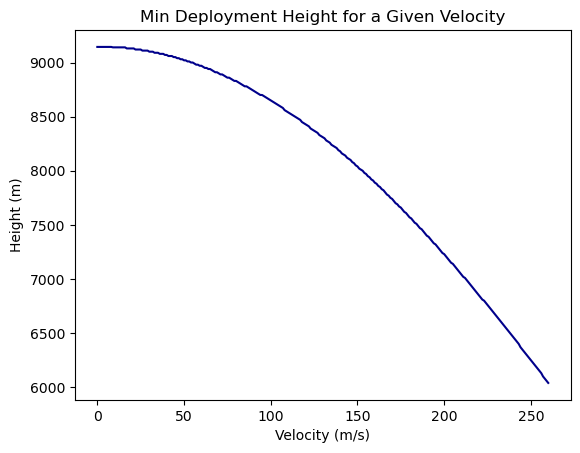

In [69]:
vel = []
height = []
for i in range(0,261):
    vel.append(LUT[i][0])
    height.append(LUT[i][1])

vel = np.array(vel)
height = np.array(height)

plt.plot(vel, height, color='darkblue')  
plt.title("Min Deployment Height for a Given Velocity")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Height (m)")

Polynomial equation:
          2
-0.04249 x - 1.165 x + 9176


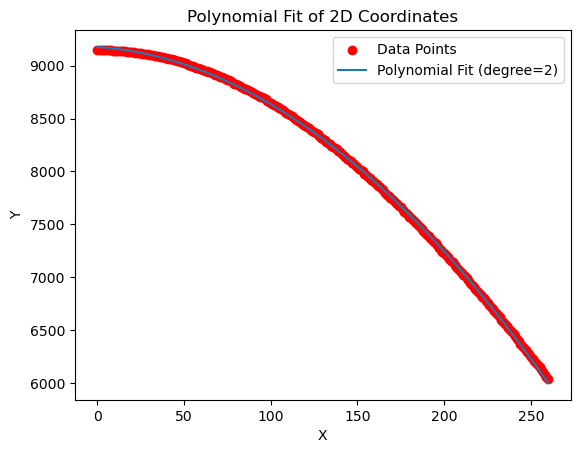

In [79]:
degree = 2

# Perform polynomial fit
coefficients = np.polyfit(vel, height, degree)
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print("Polynomial equation:")
print(polynomial)

# Generate x values for plotting the polynomial fit
x_fit = np.linspace(min(vel), max(vel), 100)
y_fit = polynomial(x_fit)

# Plot the original data points
plt.scatter(vel, height, color='red', label='Data Points')

# Plot the polynomial fit
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (degree={degree})')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Polynomial Fit of 2D Coordinates')
plt.show()

In [81]:
print(coefficients)

[-4.24930244e-02 -1.16477523e+00  9.17646511e+03]


In [8]:
mle.quit()